In [1]:
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from time import time
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score, log_loss
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import graphviz

pd.options.mode.chained_assignment = None  # default='warn'


In [2]:
def preprocessdataframe (df):
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    imputer = imputer.fit(df.loc[:,['Age']])
    df.loc[:,'Age'] = imputer.transform(df.loc[:,['Age']])

    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    imputer = imputer.fit(df.loc[:,['Fare']])
    df.loc[:,'Fare'] = imputer.transform(df.loc[:,['Fare']])

    df.Embarked = df.Embarked.fillna('S')

    df = pd.get_dummies(data=df, columns=['Embarked', 'Pclass', 'Sex'])

    return df

In [3]:
def showroccurve(fpr, tpr, roc_auc, label, color):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color=color,
             lw=lw, label='ROC curve - {0} (area = {1:0.2f})'.format(label, roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
def showmultiroccurve(params): #this should be a list of dictionaries of fpr, tpr, roc_auc, label, and color
    plt.figure()
    lw = 2
    for param in params:
        plt.plot(param["fpr"], param["tpr"], color=param["color"],
             lw=lw, label='ROC curve - {0} (area = {1:0.2f})'.format(param["label"],param["roc_auc"]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
def showdecisiontree(model, feature_names, name):
    dot_data = tree.export_graphviz(model, out_file=None,
         feature_names=feature_names,
         class_names=['Did not survive', 'Survived'],
         filled=True, rounded=True,
         special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.render(name)
    return True

In [6]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values = np.nan, strategy = 'mean'))])
#,    ('scaler', StandardScaler()) --pulled this out

categorical_features = ['Embarked', 'Sex', 'Pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators= 500, min_samples_split = 0.01, min_samples_leaf = 0.1, min_impurity_decrease = 0.0001, max_features = 3, max_depth = 4))])

In [7]:
df = pd.read_csv('~/Documents/GitHub/TiberDataScienceLearning/Data/Titanic/train.csv')
y = df[['Survived']]
x = df[['Pclass','Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

Random Forest: score =  0.7877094972067039
Random Forest: roc_auc =  0.7732542819499342
Random Forest: log_loss_score =  0.464729285278056


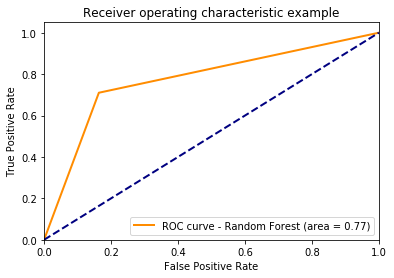

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

#we don't need to preprocess here because the Pipeline presumably does it for us
#x_train = preprocessdataframe(x_train)
#x_test = preprocessdataframe(x_test)

model = clf.fit(x_train, y_train['Survived'])
y_predictions = model.predict(x_test)
y_probabilities = model.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predictions)
roc_auc = roc_auc_score(y_test, y_predictions)
log_loss_score = log_loss(y_test, y_probabilities)
score = clf.score(x_test, y_test)
label = 'Random Forest'
print("Random Forest: score = ", score)
print("Random Forest: roc_auc = ", roc_auc)
print("Random Forest: log_loss_score = ", log_loss_score)
showroccurve(fpr, tpr, roc_auc, label, 'darkorange') 